In [110]:
include("Acor.jl")
include("generic.jl")
import Pkg
#using .Acor
using Pkg
using IJulia
using Distributions
using Statistics
using Dates
using GLM
using LinearAlgebra
using DataFrames
using Plots
Pkg.add("StatsPlots")
using StatsPlots

make: Nothing to be done for `all'.


   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [111]:
# Generates the path with steps number of steps. 
# autoreg parameters
a = 0.9
b = 2
steps = 10000

function get_next_step(previous::Float64) 
    w = rand(Normal(0,1))
    next_val = (a * previous) + (b * w)
end

function get_init_state() 
    init_sd = b^2 / (1-a^2)
    init_state = rand(Normal(0,init_sd))
end

function asim(start_state, step_function, iters = 1000) 
    curr_state = start_state
    path = Float64[]
    for i in 1:iters 
        path = push!(path,curr_state)
        curr_state = step_function(curr_state)
    end
    return path
end

start_state = get_init_state()
visited = asim(start_state, get_next_step, steps)

10000-element Vector{Float64}:
 -13.096783108408719
 -11.664948251361167
 -10.128086351366578
  -9.086278824944417
  -6.520131370554498
  -5.724323353454139
  -4.40910607102806
  -3.4731702627508296
  -4.517215584894117
  -5.553840452919297
  -5.725614478378374
  -8.875649835546252
  -8.688405926647205
   ⋮
  -2.5247327427669544
   0.36658875894065046
   2.0903869895015728
   2.8792356830447328
   2.96081414509123
   0.10125732135746546
  -1.7261735316676616
  -1.6194945432098968
  -4.61330852475577
  -3.045351563372992
  -3.654540042236536
  -3.0584392337679347

In [112]:
# Computes the autocorrelation function
function c_est(visited_states, t) 
    n = length(visited_states)
    denom = n - abs(t)
    coeff = 1 / denom
    mean_states = mean(visited_states)
    sum = 0
    for i in 0:(denom-1)
        to_add1 = visited_states[i+1] - mean_states
        to_add2 = visited_states[i+abs(t)+1] - mean_states
        to_add = to_add1 * to_add2
        sum = sum + to_add
    end
    return coeff * sum
end

function c_est_series(visited_states)
    retVal = Float64[]
    for i in 0:(length(visited_states)-1)
        retVal = push!(retVal, c_est(visited_states, i))
    end
    return retVal
end

visited_r = [11.378341,  3.040293,  3.706131,  3.588657,  3.421660,  3.064727,  3.174517,  0.847108,  -1.395752,  0.718080,  -2.704352,  3.390866,  0.944065,  2.779217,  4.067337,  3.519367,  -0.094823,  0.388568,  -1.827668,  -3.042912,  -1.094485,  -3.644110,  -1.424836,  -0.277401,  0.494308,  2.007819,  4.362086,  2.486124,  2.131275,  1.978374,  -0.352042,  4.466295,  1.632811,  0.771412,  1.972535,  -0.126209,  2.230477,  -1.852793,  -1.337260,  -4.690331,  -3.832333,  -6.502391,  -2.160378,  -1.405794,  -2.718718,  -1.042092,  -0.098979,  -0.937486,  4.163309,  1.377714,  0.496870,  6.800749,  3.926455,  1.400369,  -0.849084,  -0.776672,  -1.409006,  1.728938,  1.662058,  0.155285,  -0.421378,  1.772747,  0.465379,  3.680226,  0.417466,  -2.880221,  -2.484564,  -2.637797,  -1.022173,  0.577757,  2.251230,  1.673508,  -0.554246,  -2.092451,  2.125081,  1.140282,  3.112025,  -0.244654,  0.616736,  0.038348,  -0.355488,  -1.284048,  3.014388,  0.932782,  -1.210358,  -1.186377,  -2.624676,  0.121786,  1.229045,  1.434224,  0.024051,  -0.646681,  2.226605,  0.362629,  -1.906989,  -1.317787,  0.556849,  -1.571179,  -0.292050,  -2.683503,  -2.000856,  0.845084,  2.795982,  -1.441120,  1.211257,  0.188163,  -0.292840,  3.227452,  2.415480,  1.777019,  5.313849,  5.630902,  1.133262,  -0.525914,  -1.003111,  1.354529,  -1.352884,  -2.842661,  -3.487254,  -2.118890,  -1.067243,  -1.665634,  -1.363842,  -2.738528,  -2.671683,  -6.520950,  -7.281749,  -2.742884,  -0.831922,  -0.688468,  0.066424,  -2.826158,  -2.947764,  0.495339,  2.412842,  4.937783,  2.821254,  2.062389,  1.238183,  1.129345,  -0.999576,  -2.700321,  -1.675815,  -1.274616,  -1.285078,  0.784333,  -3.927483,  -2.622385,  4.928704,  0.812072,  -3.219465,  0.684847,  -2.005943,  -0.384814,  -1.223692,  -3.700130,  -0.455241,  -1.206743,  0.367551,  -0.201023,  -0.007453,  0.026854,  -0.718382,  -0.425401,  -2.308679,  0.821271,  -0.750079,  -3.674096,  -4.058858,  -3.835231,  -3.305118,  -1.839807,  -0.329584,  -2.365288,  0.681738,  1.612095,  2.483934,  1.656414,  -0.878588,  4.728422,  5.889455,  2.014231,  -2.112266,  -2.770310,  -1.588914,  -2.798695,  -3.152053,  -2.773792,  -4.179750,  -1.551558,  -2.834895,  0.235010,  -0.221709,  3.064623,  1.314762,  0.935419,  4.378133,  2.258582,  0.054366,  -0.920758,  0.861197,  -0.574517,  -2.648932,  -4.369070,  -2.189434,  -2.335663,  -2.420608,  0.400181,  1.737208,  0.786617,  -0.628150,  -1.218251,  -0.756532,  -3.691516,  -2.626300,  -0.283104,  -1.833515,  -4.029973,  -2.586565,  -2.460349,  -4.040648,  -0.996955,  -3.605295,  0.206397,  5.138270,  4.089175,  -0.309864,  -2.810026,  -3.223237,  -1.698918,  1.639875,  1.085591,  3.033963,  -1.304007,  1.701253,  1.653939,  -0.308857,  -3.692879,  -2.913405,  -3.666859,  -2.197791,  0.281296,  -2.398347,  -2.526655,  3.945452,  1.535984,  -0.119229,  -2.911145,  -3.197195,  -1.585812,  2.317505,  5.158949,  3.413559,  -0.240485,  0.689511,  0.356599,  -0.202196,  -1.114063,  -1.547902,  -1.160084,  -1.056670,  -3.828548,  -2.547069,  -4.502648,  -2.907504,  -1.310874,  4.631950,  -1.511231,  -1.971401,  -1.214069,  3.268409,  0.278045,  0.170430,  -0.336658,  -1.600089,  -0.572713,  0.129522,  -0.464857,  -1.222380,  2.840002,  2.369692,  -0.417577,  -1.729781,  -0.671897,  3.705293,  5.777231,  3.839074,  -0.489422,  -0.857859,  -0.773535,  1.237963,  -0.834289,  -2.081447,  -1.883261,  -0.353593,  -1.304470,  -1.937729,  -2.081619,  -3.287051,  -5.828677,  -0.891509,  -1.934984,  -1.941322,  -1.697572,  -3.503398,  0.512871,  0.451045,  0.889691,  -1.330297,  -2.312377,  -4.154192,  -1.305363,  -0.066610,  0.188237,  -2.136456,  1.243700,  2.698978,  -1.485858,  -0.165999,  -1.480483,  -2.393581,  -2.731521,  -1.902711,  -2.257191,  0.248490,  -0.473512,  -2.802859,  -0.867159,  -1.690381,  0.967874,  -1.964625,  0.793579,  -0.062690,  0.237001,  -0.744234,  -3.829206,  -3.186686,  -1.467142,  -0.852352,  -0.021884,  -2.549461,  -3.011259,  0.208945,  -1.158407,  0.869028,  -1.412091,  -3.183378,  -3.233046,  -0.621595,  -1.459713,  -1.753830,  -1.865799,  -3.092901,  0.294382,  -0.474378,  0.369187,  1.662152,  -2.054878,  -2.515980,  -5.508581,  -1.691005,  -1.210542,  -0.025705,  -1.557030,  0.195213,  -0.549641,  -1.429857,  -1.424288,  0.991952,  -1.466638,  0.957783,  -1.416549,  -1.449250,  -1.545134,  -0.718451,  -1.903007,  -1.908329,  -2.408986,  2.349377,  3.365100,  1.280189,  1.212727,  -1.154752,  -3.334045,  -3.645570,  -3.384066,  -4.674558,  -3.314515,  -1.742915,  -0.359059,  0.662300,  1.573470,  1.596316,  1.930976,  -0.085472,  1.560787,  0.323831,  0.382609,  1.489161,  6.089230,  2.940107,  3.320983,  1.288239,  0.492679,  -1.806158,  -1.366976,  -1.675481,  1.023294,  -3.297425,  -3.540330,  -1.002935,  -1.319127,  -1.397775,  -0.792731,  0.150515,  4.102507,  1.164407,  1.946659,  1.526176,  -1.579594,  0.178168,  -0.571845,  -0.673870,  0.089257,  0.493644,  -1.526070,  0.711049,  2.091975,  1.098557,  1.978711,  0.033931,  -1.824653,  -0.277458,  3.887078,  3.344669,  0.929701,  -1.403732,  -0.014149,  -1.225462,  -0.268758,  -1.819939,  -1.545964,  0.745513,  -1.296821,  0.195932,  0.825816,  -0.712194,  -0.192826,  -0.265903,  -2.018242,  0.074214,  -5.598337,  -0.545882,  -0.916416,  -3.801836,  -2.848631,  -1.377065,  0.620555,  1.663332,  1.099970,  -0.263556,  2.007162,  -0.384639,  -0.978788,  -0.580249,  -1.989884,  -0.610183,  0.309995,  0.819423,  -1.496016,  1.021174,  -1.812085,  -2.194982,  -1.527749,  0.842662,  -1.386355,  4.504201,  1.638779,  1.005223,  -2.216705,  -3.398413,  -2.769686,  -0.465798,  -1.732311,  0.345536,  -0.403948,  0.528924,  -0.584878,  -1.642822,  0.527797,  0.787371,  0.091378,  -0.433261,  -2.240111,  -3.706250,  -0.217036,  1.930878,  3.264766,  0.444820,  2.161154]
calc_acfs = c_est_series(visited_r)

500-element Vector{Float64}:
  5.2259081362559945
  2.662890747595167
  1.4249611715527812
  0.6536013179212864
  0.298797478555221
  0.1437901232627319
  0.051132053364117296
 -0.6171489324881831
 -0.5876282174704631
 -0.3683615052093735
 -0.4842275372337799
 -0.25653766721979
 -0.41091515461400474
  ⋮
 -1.305813742126524
 -0.817452092599028
  0.8680457099369394
  0.3332914338248708
  0.7385809561398726
  0.11636039051950395
 -0.6992757167967675
  7.242341690587214
 12.95332074309674
 18.342447360753606
  8.830140653757784
 29.3162277310911

In [113]:
function lambda(t, M)
    if abs(t) <= M
        retVal = 1- (abs(t) / M)
        #retVal = 1 #used for testing against rectangular window
        return retVal
    else 
        return 0
    end
end 

function calc_t_int(M,acfs) 
    #sum = 0
    #n = length(acfs)-1
    n = M
    lower_bound = 1 #1-n
    upper_bound = n-1
    sum = lambda(0, M)
    for t in lower_bound:upper_bound
        p_hat = acfs[t+1] / acfs[1]
        to_add = p_hat * lambda(t,M)
        sum = sum + (2*to_add)
    end
    return sum
end

function calc_t_series(poss_Ms, acfs) 
    retVal = Float64[]
    for n in 1:length(poss_Ms) 
        to_add = calc_t_int(poss_Ms[n],acfs)
        retVal = push!(retVal, to_add)
    end
    return (0.5*retVal)
end

function find_greater(arr1, arr2) 
    for val in 1:length(arr1)
        if arr1[val] > arr2[val]
            return val
        end
    end
    return -1
end

function sokal(acfs, c) 
    poss_Ms = 1:(length(acfs)-1)
    ct_ints = c*calc_t_series(poss_Ms, acfs)
    retVal = find_greater(poss_Ms, ct_ints)
    return poss_Ms[retVal]
end

M = sokal(calc_acfs, 5)
println(calc_t_int(M, calc_acfs))
exp_m = 1 + 2*(0.5/(1-0.5))
exp_m

2.3851810946605716


3.0

In [140]:
# for comparison between acor values and my values
my_time_sokal = Float64[]
acor_time = Float64[]

a= -0.8
for i in 1:10
    start_state = get_init_state()
    visited = asim(start_state, get_next_step, steps)
    calc_acfs = c_est_series(visited)
    println(mean(visited))
    maxLag = 100
    acor_sugg = Acor.acor(visited, maxLag)
    println(acor_sugg)
    acor_time = push!(acor_time, acor_sugg.tau)
    M = sokal(calc_acfs, 10)
    my_est = calc_t_int(M, calc_acfs)
    my_time_sokal = push!(my_time_sokal, my_est)
end

true_time = 1 + 2*(a/(1-a))
println(acor_time)
println(my_time_sokal)
1 + 2*((-0.8)/(1+0.8))

0.006950763659529622
(mean = 0.006950763659529693, sigma = 0.011854599164424098, tau = 0.12796734870993653, status = 0)
0.004253384109305467
(mean = 0.00425338410930549, sigma = 0.010282516736630028, tau = 0.10052047407513069, status = 0)
0.010740325217274199
(mean = 0.01074032521727428, sigma = 0.01042205001658192, tau = 0.09462371628663582, status = 0)
0.011431774374060668
(mean = 0.011431774374060698, sigma = 0.009941471654584005, tau = 0.09142277360548398, status = 0)
0.007732848944019034
(mean = 0.007732848944019014, sigma = 0.011623230839738164, tau = 0.11837658557902817, status = 0)
-0.0007488355633475891
(mean = -0.0007488355633475532, sigma = 0.009758726488576425, tau = 0.08911278362044554, status = 0)
-0.0031702534061946778
(mean = -0.003170253406194709, sigma = 0.013397123567066432, tau = 0.1541626859153556, status = 0)
-0.004498770966630736
(mean = -0.004498770966630731, sigma = 0.00978545367958976, tau = 0.08584969073684796, status = 0)
-0.02169280687095899
(mean = -0.0216

0.11111111111111105

In [171]:
# New method from paper!
function get_desh_weights(results, p, q, r)
    new_weights = Float64[]
    #println("weights function")
    for row in 1:nrow(results)
        #println(row)
        weight = (results.lengths[row] ^ p) / (results.errs[row] ^ q)
        push!(new_weights, weight)
    end
    return new_weights
end

function get_fit_length(rhs_val, lhs_val, m)
    coeff = sqrt(1 + (m^2))
    retVal = abs(rhs_val - lhs_val)
    retVal = coeff * retVal
    return retVal
end

function get_fit_err(x, y, m, c, lhs, rhs)
    to_repeat = [c]
    to_sum = y - (m * x) - repeat(to_repeat, length(y))
    to_sum = to_sum .^ 2
    sum_val = sum(to_sum[lhs:rhs])
    num = sqrt(sum_val)
    denom = rhs - lhs
    return num / denom
end

function desh_method(x, y, lims, n)
    slopes = Float64[]
    lengths = Float64[]
    errs = Float64[]
    xL = Float64[]
    xR = Float64[]
    ints = Float64[]
    start_time = now()
    for lhs in 1:lims
        for rhs in 1:lims
            if (rhs - lhs) > n
                data = DataFrame(X = x[lhs:rhs], Y = x[lhs:rhs])
                lin_model = GLM.lm(@formula(Y ~ X), data)
                
                m = GLM.coef(lin_model)[2] 
                c = GLM.coef(lin_model)[1]
                fit_length = get_fit_length(x[rhs], x[lhs], m)
                fit_err = get_fit_err(x, y, m, c, lhs, rhs)

                push!(slopes, m)
                push!(lengths, fit_length)
                push!(errs, fit_err)
                push!(xL, x[lhs])
                push!(xR, x[rhs])
            end
        end
    end
    
    end_time = now()
    println(end_time - start_time)
    retVal = DataFrame(slopes=slopes, lengths=lengths, errs=errs, xL=xL, xR=xR)
    return retVal
end

function get_slopes_sides(results, weights; plot_title="", plot_right=false, plot_others=false)
    kern = KernelDensity.kde(results.slopes, weights=weights)  # Adjust bandwidth if needed
    #println(kern)
    #best_slope = findmax(kern).index
    
    lhs_kern = KernelDensity.kde(results.xL, weights=weights)
    #best_lhs = lhs_kern.x[findmax(lhs_kern.y).index]
    
    rhs_kern = KernelDensity.kde(results.xR, weights=weights)
    #best_rhs = rhs_kern.x[findmax(rhs_kern.y).index]
    
    if plot_others
        plot(kern.x, kern.y, label="Slopes")
        plot!(lhs_kern.x, lhs_kern.y, label="LHS")
    end
    
    if plot_right
        plot(rhs_kern.x, rhs_kern.y, label="RHS")
        title!(plot_title)
    end
    
    #return DataFrame(best_slope=best_slope, best_lhs=best_lhs, best_rhs=best_rhs)
    return rhs_kern
end

function get_log(acfs::Vector{<:Real})
    return log.(abs.(acfs))
end

get_log (generic function with 1 method)

In [177]:
# First, we get the simulations acfs
#poss_as = [-0.9, -0.7, -0.5, 0.5, 0.7, 0.9, 0.99]
poss_as = [-0.8]
steps = 10000
dict = Dict{String, Vector{Float64}}()

for a in poss_as
    states_visited = asim(get_init_state(), get_next_step, steps)
    acf_df = c_est_series(states_visited)
    dict[string(a)] = acf_df
end

old_ms = Float64[]
new_ms = Float64[]
ps = Int[]
qs = Int[]
as = Float64[]
real_m = Float64[]
rs = Float64[]
results_ar1s = Vector{DataFrame}()
poss_ps = [1, 2, 3, 4, 5]
poss_qs = [1, 2, 3, 4, 5]
poss_rs = [0]

# Now, we do the method. 
for a in poss_as
    acf = dict[string(a)]
    
    stop_search_index = findfirst(x -> x <= 0, acf)
    
    
    if stop_search_index !== nothing
        stop_search = 4 * stop_search_index
    else
        stop_search = length(acf)
    end

    n = 3
    #stop_search = min(max(stop_search, 10), 500)
    
    y = get_log(acf)[1:stop_search]
    x = collect(0:(stop_search-1))
    lim = length(y)
    
    results_ar1 = desh_method(x, y, lim, n)
    push!(results_ar1s, results_ar1)
end

1 millisecond


-0.8
2
1 millisecond


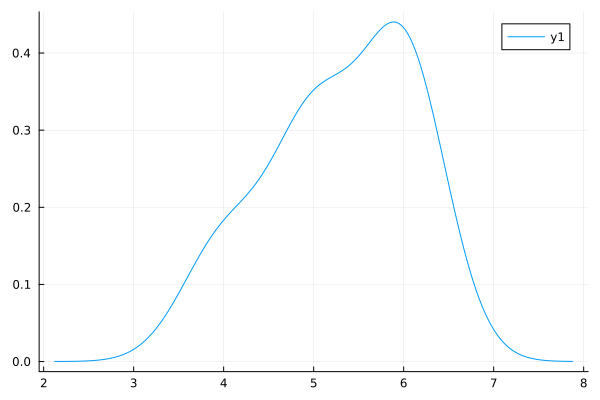

INDX:5.886989946336291 p:1 q:1


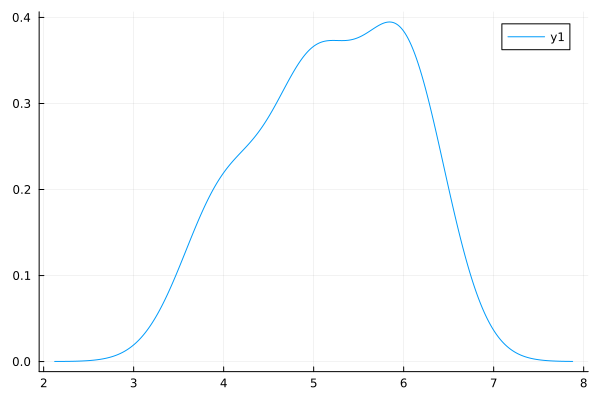

INDX:5.842007888835877 p:1 q:2


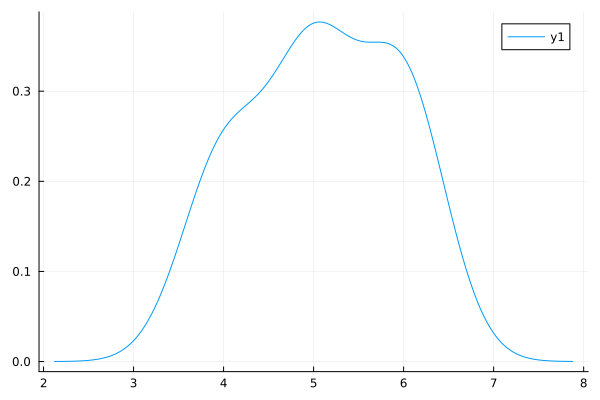

INDX:5.0688787755475095 p:1 q:3


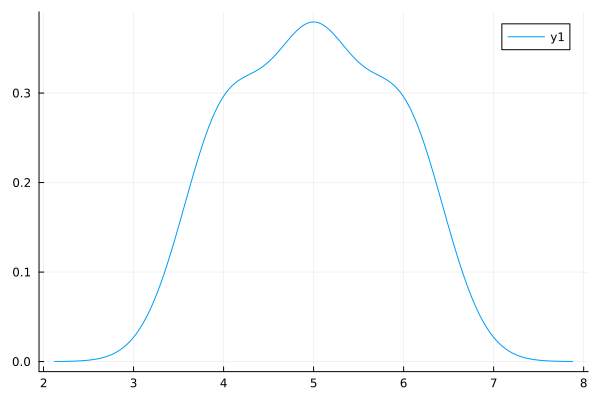

INDX:4.998594310703112 p:1 q:4


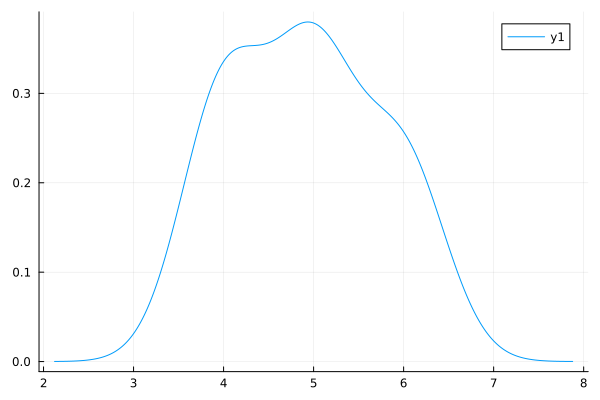

INDX:4.936743981640043 p:1 q:5


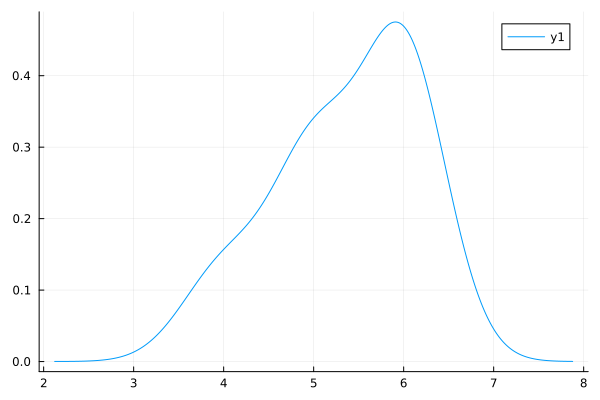

INDX:5.909480975086498 p:2 q:1


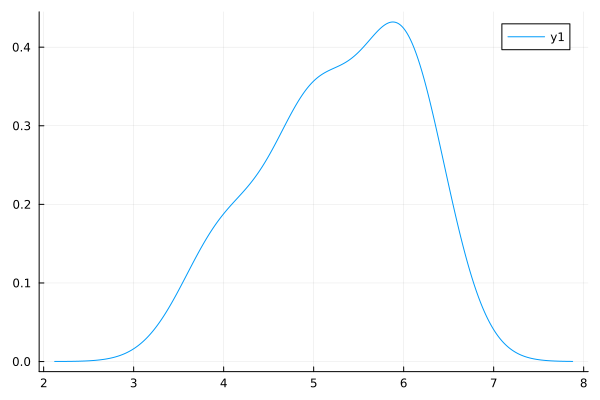

INDX:5.878555810554963 p:2 q:2


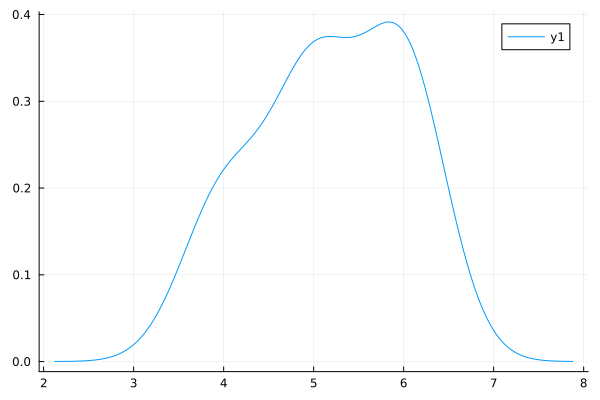

INDX:5.836385131648325 p:2 q:3


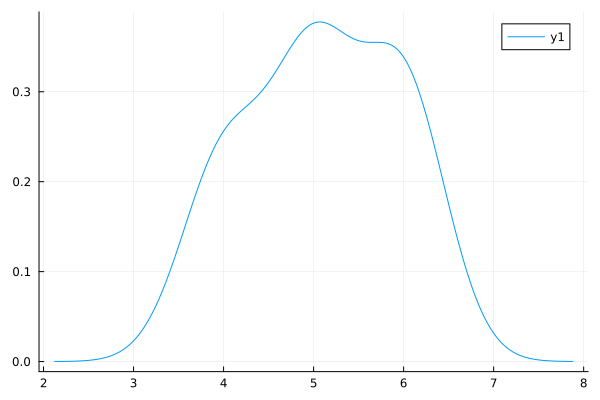

INDX:5.0688787755475095 p:2 q:4


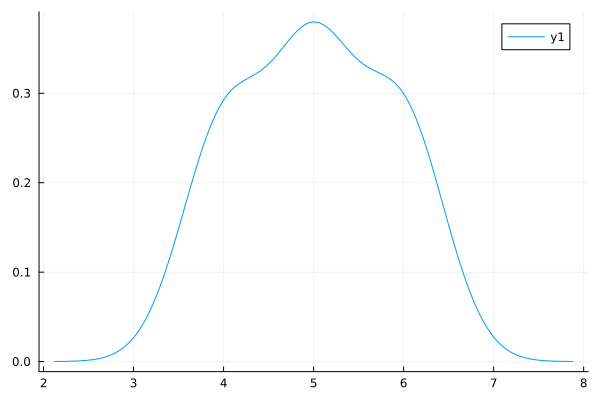

INDX:5.0042170678906635 p:2 q:5


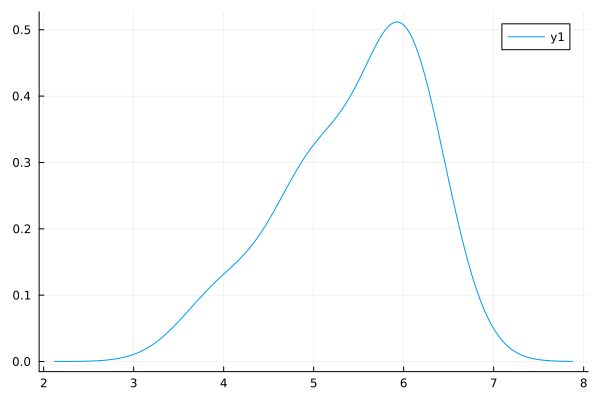

INDX:5.926349246649154 p:3 q:1


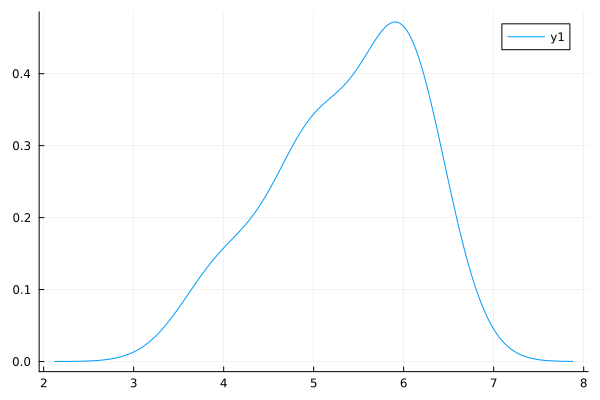

INDX:5.906669596492722 p:3 q:2


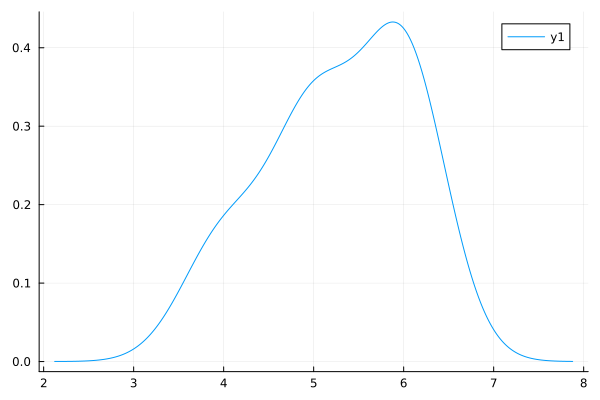

INDX:5.878555810554963 p:3 q:3


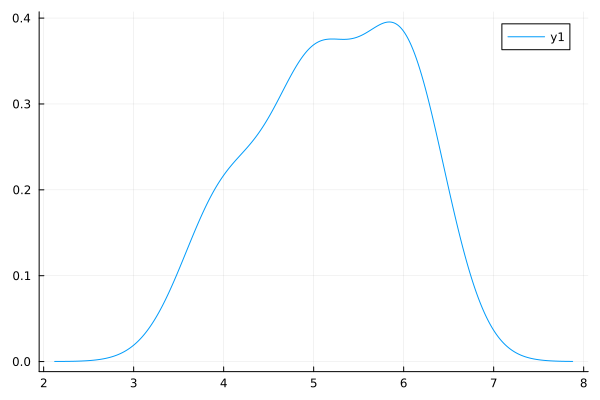

INDX:5.839196510242101 p:3 q:4


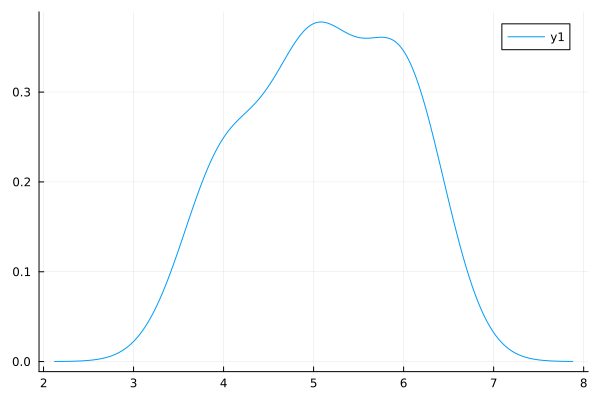

INDX:5.082935668516389 p:3 q:5


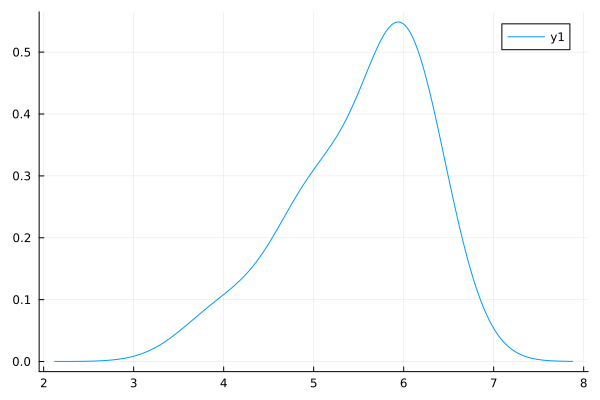

INDX:5.937594761024257 p:4 q:1


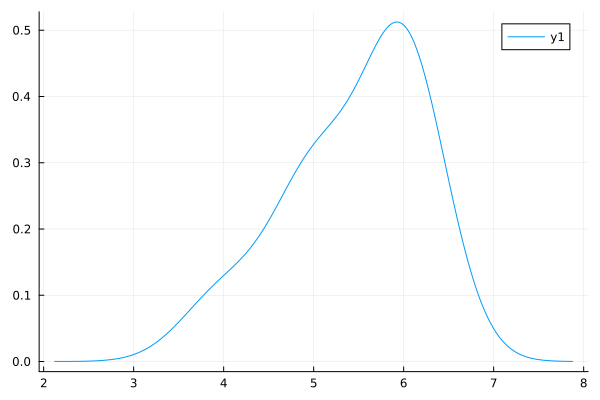

INDX:5.923537868055377 p:4 q:2


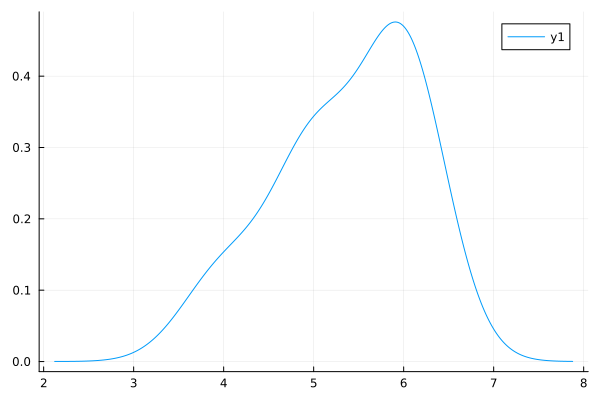

INDX:5.906669596492722 p:4 q:3


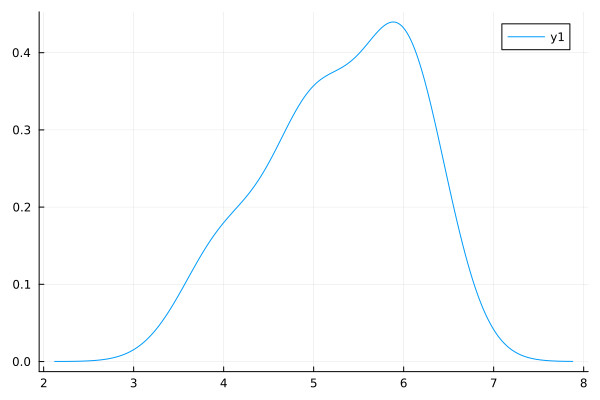

INDX:5.884178567742515 p:4 q:4


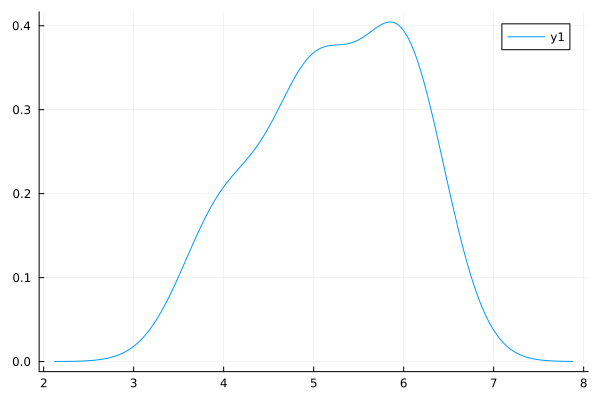

INDX:5.850442024617204 p:4 q:5


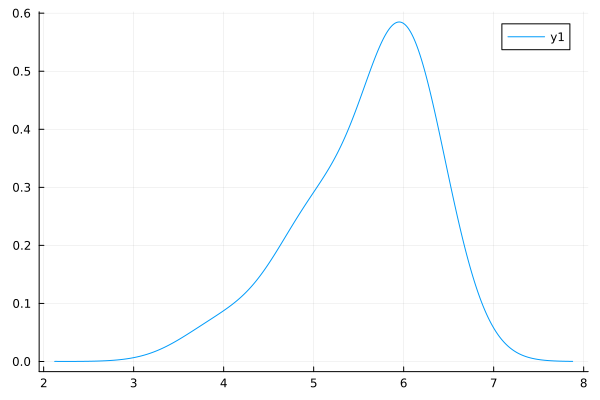

INDX:5.94884027539936 p:5 q:1


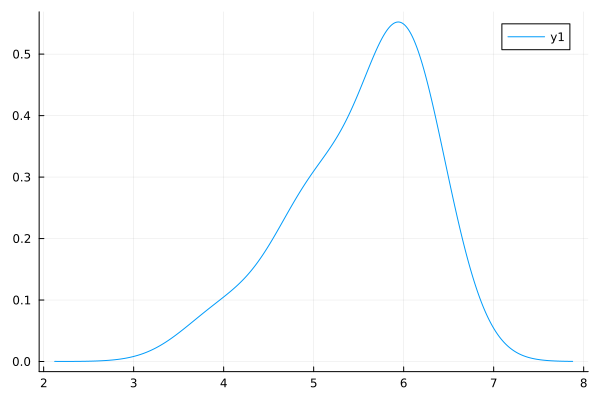

INDX:5.940406139618033 p:5 q:2


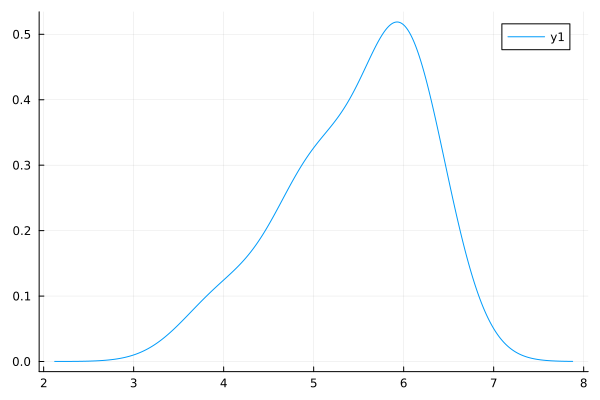

INDX:5.926349246649154 p:5 q:3


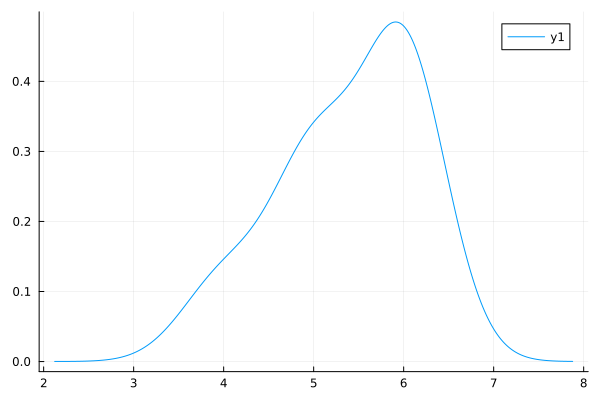

INDX:5.912292353680273 p:5 q:4


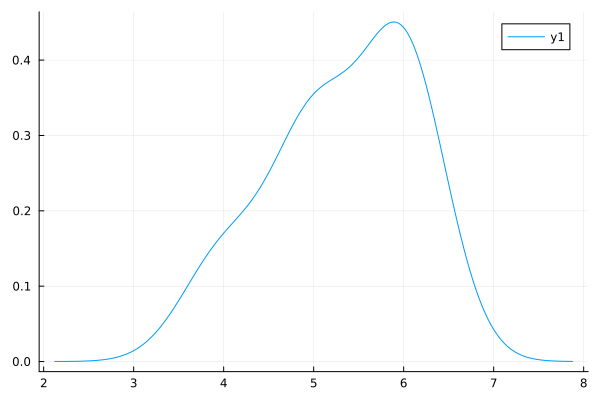

INDX:5.889801324930067 p:5 q:5
1.2512240409851074


In [180]:
for a in poss_as
    println(a)
    start_time = time()
    c = 4
    M_upper_bound = steps
    
    acf = dict[string(a)]
    
    m = sokal(acf, c)
    m_suggest = calc_t_int(m, acf)
    println(m)
    
    #stop_search = findfirst(x -> x <= 0, acf)
    #stop_search = stop_search_index !== nothing ? 1.5 * stop_search_index : length(acf)
    stop_search = m
    
    n = 3
    #stop_search = 100
    stop_search = stop_search < 7 ? 7 : stop_search
    
    y = get_log(acf)[1:stop_search]
    x = collect(0:(stop_search-1))
    lim = length(y)
    results_ar1 = desh_method(x, y, lim, n)
    
    for p in poss_ps
        for q in poss_qs
            for r in poss_rs
                exp_m = 1 + 2 * (a / (1 - a))
                
                push!(real_m, exp_m)
                push!(old_ms, m_suggest)
                
                new_weights = get_desh_weights(results_ar1, p, q, r)
                vars_ar1 = get_slopes_sides(results_ar1, new_weights)
                
                #push!(new_ms, vars_ar1.best_rhs)
                #println(vars_ar1)
                #println(new_weights)
                
                idx = vars_ar1.x[findmax(vars_ar1.density)[2]]
                display(plot(vars_ar1.x, vars_ar1.density))
                print("INDX:")
                print(idx)
                print(" p:")
                print(p)
                print(" q:")
                println(q)
                
                push!(ps, p)
                push!(qs, q)
                push!(as, a)
                push!(rs, r)
            end
        end
    end
    
    end_time = time()
    println(end_time - start_time)
end